In [29]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from utils import *

In [30]:
model = AutoEncoder(in_channels=3)
model.load_state_dict(torch.load('trained_models/auto_encoder_rgb.pt'))

<All keys matched successfully>

In [31]:
# Get latent variable
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=9)
test_data = gen.get_full_data_set(training=False)

x_test, y_test = test_data

# Convert y_train and y_test into one-hot vectors
y_test = to_one_hot_rgb(y_test)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

images, _ = iter(test_loader).next()
latent = model.encoder(images)

mean = latent.mean(dim=0)
std = (latent-mean).pow(2).mean(dim=0).sqrt()

z = torch.randn(32, 16) * std + mean

z

tensor([[-3.4113,  1.0344,  0.2677, -2.2813, -0.9336,  0.9508, -2.7084,  0.3336,
          0.8131,  0.6859, -0.3532,  0.6466, -3.2352,  0.5626,  2.2556,  2.0837],
        [-4.1943, -0.3311, -2.2900,  3.9148, -4.0928, -2.2132, -3.0473, -0.9331,
         -1.7678, -2.2762, -0.3130,  1.2464, -1.0134,  0.0408,  1.1971,  3.5651],
        [-2.0172, -0.1361,  1.5994,  1.6553, -0.1174, -2.0650, -0.6082, -3.1524,
          0.8008,  0.7230, -0.1633, -1.2714,  0.8616, -0.3794,  2.5424, -0.6881],
        [ 0.1088,  4.3004, -2.0422,  0.8285, -0.2724,  0.9098, -2.4508, -1.9337,
          1.0287, -0.6740,  0.6892,  2.0785, -1.6027, -1.8967, -0.5954,  0.1758],
        [-4.2717,  1.6263,  1.2040, -0.9411,  0.9820,  1.2187, -2.3464, -0.2907,
         -0.2569,  0.5563,  0.0189,  0.0620,  1.1722, -0.7637,  1.9137,  1.9333],
        [-1.5251,  0.8530,  0.3183, -1.4621,  0.5116, -3.0546, -1.9192, -1.4108,
         -1.1340, -1.0149,  2.0222, -1.0928, -0.4325,  2.9495,  0.9441,  2.5835],
        [-4.2041,  0.5

In [32]:
model.eval()
with torch.no_grad():
    generated_image = model.decoder(z)[0]

In [33]:
generated_image.shape

torch.Size([3, 28, 28])

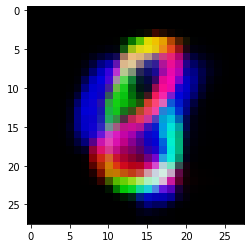

In [34]:
plt.imshow(generated_image.permute(1, 2, 0))

In [35]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 2, 2))
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3)

In [36]:
z = model.decoder[0:5](z)

c1 = model.decoder[5](z)
c1 = F.relu(c1)

c2 = model.decoder[7](c1)
c2 = F.relu(c2)

c3 = model.decoder[9](c2)
c3 = F.relu(c3)


c4 = model.decoder[11](c3)


c1.shape, c2.shape, c3.shape, c4.shape


(torch.Size([32, 64, 4, 4]),
 torch.Size([32, 32, 7, 7]),
 torch.Size([32, 16, 14, 14]),
 torch.Size([32, 3, 28, 28]))

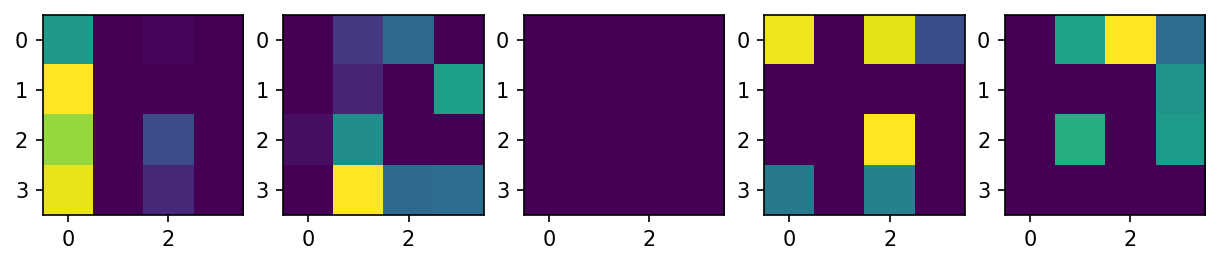

In [37]:
# Visualize som feature maps from c1
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c1[0][i])
        
    plt.show()

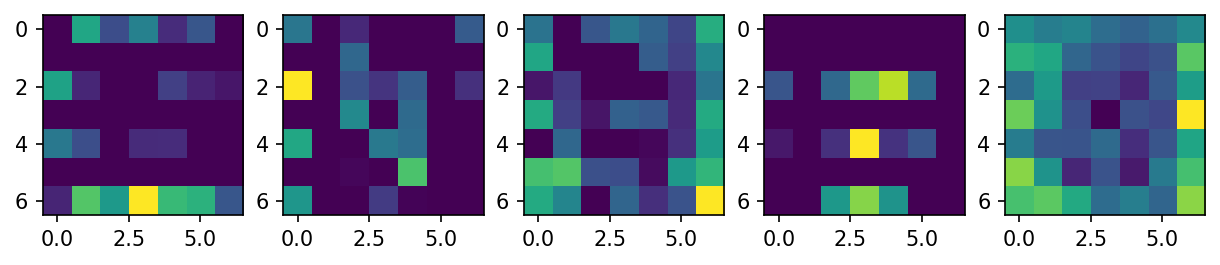

In [38]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c2[0][i])
        
    plt.show()

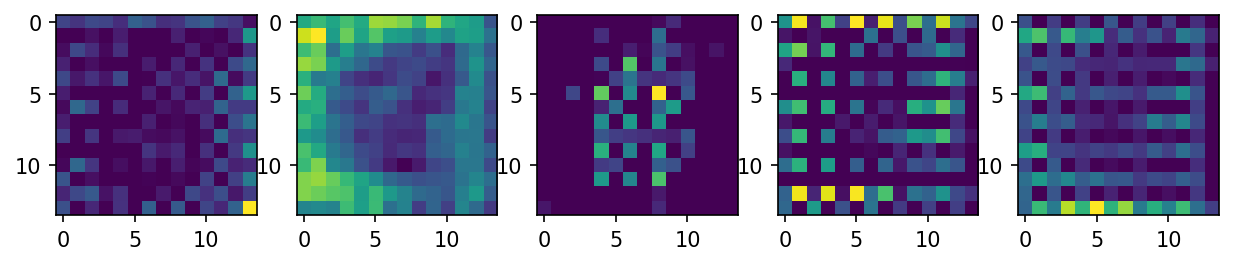

In [39]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c3[0][i])
        
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


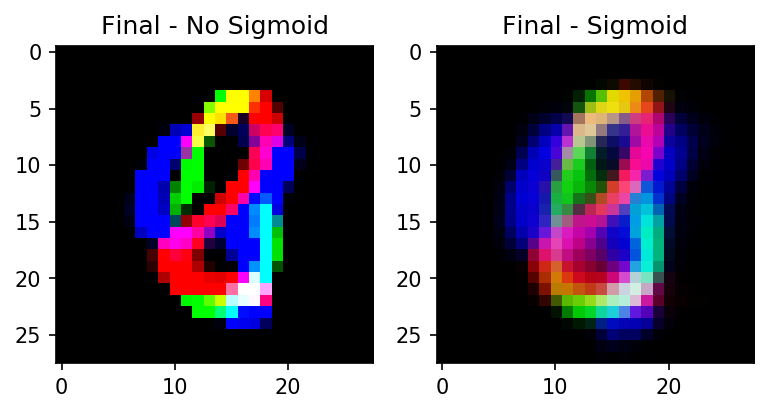

In [40]:
with torch.no_grad():    
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 4), dpi=150)

    # Plot each image in a separate subplot
    axs[0].imshow(c4[0].squeeze(0).permute(1, 2, 0))
    axs[0].set_title('Final - No Sigmoid')
    axs[1].imshow(F.sigmoid(c4[0].permute(1, 2, 0)))
    axs[1].set_title('Final - Sigmoid')

        
    plt.show()
    